# Chap3: word2vec

In [52]:
import os
from pathlib import Path
import sys

sys.path.append(os.path.join(Path().resolve(), 'deep-learning-from-scratch-2'))

## 3.1 推論ベースの手法と NN

- カウントベースだと単語の種類が増えると行列が巨大になってしまい、次元を削減するための特異値分解 (SVD) も $$O(n^3)$$ の計算量
- マスクされた部分の単語を推測する推論ベースの手法
- 推論ベースでは NN に固定長の vector を入力するため、例えば文を one-hot 表現にして入力

## 3.2 word2vec

- word2vec では continuous bag-of-words (CBOW) と skip-gram が使われる (どっちも NN)

### 3.2.1 CBOW の推論処理

- CBOW は context から target (中央の単語) を推測する
- 入力層は context として入力する単語の数
- 入力層から中間層に変換する全結合層の重みが単語の分散表現となる
  - これは学習が進むと更新されていき、「意味」もエンコードされるようになっていく
  - 中間層のニューロンの数が入力層のニューロンの数より少ないことで情報が密にエンコードされる
- 入力層が複数あるような全結合のネットワーク
- CBOW の推論処理のコードは下記


In [53]:
import ch03
from ch03 import cbow_predict

cbow_predict??

Type:        module
String form: <module 'ch03.cbow_predict' from '/Users/oka/git/zero-deep-2/deep-learning-from-scratch-2/ch03/cbow_predict.py'>
File:        ~/git/zero-deep-2/deep-learning-from-scratch-2/ch03/cbow_predict.py
Source:     
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)


### 3.2.2 CBOW の学習

- 出力層のスコアに Softmax を掛けると、前後の単語を入力したときに中央に出現する単語の確率になる

### 3.2.3

- 出力側の重みにも単語の意味がエンコードされている
- word2vec では入力側の重みだけが用いられることが多い
- GloVe では2つの重みを足し合わせている

## 3.3 学習データの準備

In [54]:
# コーパスを作成
import common.util
from common.util import preprocess

text = 'You say goodbye and I say hello .'
#text = 'I say high you say low .'
#text = 'You say stop and I say go go go .'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6 7]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '', 7: '.'}


In [55]:
# corpus から context, target を作成
from common.util import create_contexts_target

create_contexts_target??

Signature: create_contexts_target(corpus, window_size=1)
Source:   
def create_contexts_target(corpus, window_size=1):
    '''コンテキストとターゲットの作成

    :param corpus: コーパス（単語IDのリスト）
    :param window_size: ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)
File:      ~/git/zero-deep-2/deep-learning-from-scratch-2/common/util.py
Type:      function


In [56]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]
 [5 7]]
[1 2 3 4 1 5 6]


In [57]:
# 3.3.2 one-hot 表現への変換
from common.util import convert_one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print(target)
print(contexts)

[[0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]]

 [[0 1 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]]

 [[0 0 1 0 0 0 0 0]
  [0 0 0 0 1 0 0 0]]

 [[0 0 0 1 0 0 0 0]
  [0 1 0 0 0 0 0 0]]

 [[0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0]]

 [[0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0]]

 [[0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 1]]]


In [58]:
## 3.4 CBOW  モデルの実装
from ch03 import simple_cbow
simple_cbow??

Type:        module
String form: <module 'ch03.simple_cbow' from '/Users/oka/git/zero-deep-2/deep-learning-from-scratch-2/ch03/simple_cbow.py'>
File:        ~/git/zero-deep-2/deep-learning-from-scratch-2/ch03/simple_cbow.py
Source:     
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads 

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

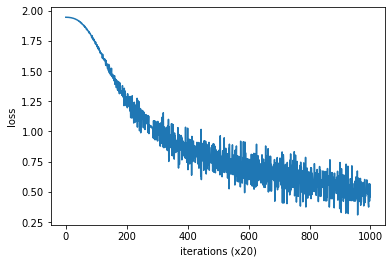

you [-1.1189663  0.5052439 -1.6265602  1.1315099 -1.1310743]
say [ 1.1154368  -1.2323933   1.2552665  -1.0733286   0.28315166]
goodbye [-0.8969616   1.2432282  -0.03492394  0.88468987 -0.9994012 ]
and [ 0.7984338 -1.0725172  1.090547  -0.6893652  1.8379582]
i [-0.8890062  1.2389067 -0.0470913  0.8861318 -0.9897599]
hello [-1.1083368  0.5293476 -1.6422112  1.112894  -1.1217715]
. [ 1.1219535 -1.0408053  1.0589536 -1.1801798 -1.7487335]


Type:        module
String form: <module 'ch03.train' from '/Users/oka/git/zero-deep-2/deep-learning-from-scratch-2/ch03/train.py'>
File:        ~/git/zero-deep-2/deep-learning-from-scratch-2/ch03/train.py
Source:     
# coding: utf-8
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_ve

In [62]:
## 3.4.1 学習コードの実装
sys.path.append(os.path.join(Path().resolve(), 'deep-learning-from-scratch-2/ch03'))
from ch03 import simple_cbow
from ch03 import train
train??

最後に出力されているのが単語のベクトル

### 3.5.2 skip-gram

- skip-gram は CBOW の context と target が逆に形
- CBOW のほうが高速だが skip-gram のほうが精度が良い

In [65]:
# skip-gram の実装
from ch03 import simple_skip_gram
simple_skip_gram??

Type:        module
String form: <module 'ch03.simple_skip_gram' from '/Users/oka/git/zero-deep-2/deep-learning-from-scratch-2/ch03/simple_skip_gram.py'>
File:        ~/git/zero-deep-2/deep-learning-from-scratch-2/ch03/simple_skip_gram.py
Source:     
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            se

### 3.5.3 カウントベース vs 推論ベース

- 語彙に単語を追加する場合、カウントベースではゼロからやりなおす必要がある
- 推論ベースでは再学習ができる
- 精度的には優劣はつけられない
- GloVe は2つを融合させたようなもの